During the corona pandamic a lot of things have changed and it has transformed the way we live. One aspect where especially in Germany things have changed is the way people pay in Germany. Before the pandamic hard cash was the prefered payment methode of many Germans. However, not only the customers also the shop owners prefered cash as this would save them the fees asociated with card payment. The pandamic has changed this. Cash has become a methode of spreading the virus and thus many people have changed their behaviour and started to pay by card. The KubeBank has noticed this trend of increased payment methode being card. Unfortunately this has brought its problems of its own. The number of frauds has increased to the extend where the bank now hired a Data-Scientist to develope a neural network to improve the fraud detection, which is currently conducted using a Logistic regression.
Due to the strict Datenschutzgrundverordnung the company has provided a dataset from their US Branch in order to train and evaluate the model.



In [6]:
import pandas as pd
import numpy as np
import seaborn as sns

The data is from https://www.kaggle.com/datasets/kartik2112/fraud-detection and is made available under the CC0: Public Domain licence.

In [7]:
data = pd.read_csv("data/fraudTrain.csv")

Challenge with other datascientists thats why already split into a dataset for testing and one for training

In [8]:
data.shape

(1296675, 23)

The training dataset contains roughly 1.3 million entries and has 23 columns.

In [9]:
data.keys()

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

The dataset contains 22 features. Some of them have to be adjusted to be usable in the prediction.
## Features that are probably interesting is the time when the transfer took place. Persumably at night there will be more fraud than during the day. The date is mostlike not as interesting so the date will be extracted and transformed 
The distance between the homelocation and the payment is probably also interesting. This can be calculated with the help of the lat/long of the vendor and the homeloaction of the card owner. The age of a person is probably relevant as well as older people persumably fall victim to scamers more often when compared to younger people. This can be extracted by calculating the timedelta between the transaction date and the date of birth of the card holder. The job, gender and category probably play also a role in detecting fraudulent transactions. As they are categorical they need to be dummified before they can be used in the dataset.

city_pop as measure big city -> more crime

Calculate Distance between the two coordinates:


In [17]:
data["merch_long"].isna().sum()

0

In [21]:
from geopy import distance
for index, row in data.iterrows():
    data.loc[index, "distance"] = round(distance.distance((row["lat"], row["long"]), (row["merch_lat"], row["merch_long"])).km)

AttributeError: 'Series' object has no attribute 'summary'

In [25]:
data["distance"].describe()

count    1.296675e+06
mean     7.611261e+01
std      2.909401e+01
min      0.000000e+00
25%      5.500000e+01
50%      7.800000e+01
75%      9.800000e+01
max      1.520000e+02
Name: distance, dtype: float64

In this section the age of the card holder will be calculated at the time of the transaction

In [29]:
from dateutil.relativedelta import relativedelta

In [40]:
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S')
data['dob'] = pd.to_datetime(data['dob'], format='%Y-%m-%d')
for index, row in data.iterrows():
    data.loc[index, "age"] = relativedelta(row['trans_date_trans_time'],row['dob']).years


In [ ]:
data.describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,6.483370e+05,4.171920e+17,7.035104e+01,4.880067e+04,3.853762e+01,-9.022634e+01,8.882444e+04,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03
std,3.743180e+05,1.308806e+18,1.603160e+02,2.689322e+04,5.075808e+00,1.375908e+01,3.019564e+05,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02
min,0.000000e+00,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00
25%,3.241685e+05,1.800429e+14,9.650000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00
50%,6.483370e+05,3.521417e+15,4.752000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00
75%,9.725055e+05,4.642255e+15,8.314000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00
max,1.296674e+06,4.992346e+18,2.894890e+04,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.371817e+09,6.751027e+01,-6.695090e+01,1.000000e+00


In this section the above mentioned variables are dummified.

In [47]:
dummy_var = ["job","gender","category"]
data = pd.get_dummies(data, columns=dummy_var,prefix=dummy_var,drop_first=True)

Next all the columns that are no longer needed will be deleted.

In [49]:
data = data.drop(["Unnamed: 0","cc_num","merchant","first","last", "street", "city", "state", "zip", 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long',
       'lat', 'long'],axis=1).shape


(1296675, 513)

After this feature generation the dataset has now 512 features and the one dependend variable.

<AxesSubplot:xlabel='is_fraud', ylabel='Percent'>

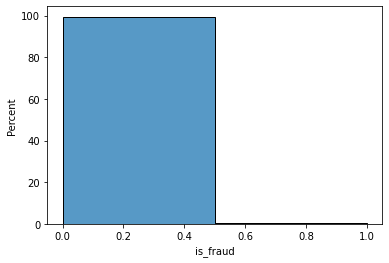

In [7]:
sns.histplot(data=data,x="is_fraud", bins=2, stat="percent")